# Tweaking figures 
### [RN] 20210212

Need to tweak some figures for paper. 

one with lag = 300, k = 0.15; other with lag = 300, k = 0.17

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
import scipy.optimize as opt

plt.rcParams['figure.figsize'] = [14, 6]

In [2]:
### code from 20210202_TuesdayMeeting to get raw data into arrays. 

def ReadFile(infile): # read infile, return contents list of each line
    read = open(infile, 'r')
    lines = read.readlines()
    read.close()
    return(lines)
# read raw data
raw = ReadFile("USA-California.tsv")

def TryFloat(val): # I want to convert nonempty data points to either floats or none so I can operate on these arrays. 
    try:
        val = float(val)
    except:
        val = None
    return val
        
# extract data 
date, cases, deaths, hospital, icu, recovered = [], [], [], [], [], []

for i in range(4, len(raw)): # split up raw data. it looks like there are bytes  b'\t' that seprate vals in addition to end characters. 
    thisset = raw[i]
    thisset = thisset.encode('utf-8') # encode data as bytes
    working = thisset.split(b'\t') # split data by byte
    for i in range(len(working)):
        working[i] = working[i].decode('utf8', 'strict') # put back as string for easier handling 
    date.append(working[0])
    cases.append(TryFloat(working[1]))
    deaths.append(TryFloat(working[2]))
    hospital.append(TryFloat(working[3]))
    icu.append(TryFloat(working[4]))
    recovered.append(working[5])


In [3]:
## final function. 

"""
Input arguements 
I0 : initial number of infected peopl e
N : population size 
k : number of people each infected person infects 
g : removal rate from infectious pool 
v : maximum number of vaccines that will be given per day, limited by manufacturing and dispersal (after development)
lag : Number of days after patient 0, or day 0, after which vaccine becomes available
A : Anti vax population, or a percent of the population that will refuse the vaccine 
d : death rate, or percept of recovered people who are actually dead and removed completely 
w : number of days after infection that a person is temporarily immune and in recovered pool before being moved back to susceptible
r : number of days it takes to rollout vaccine at half maximum capacity
dt : time step. this is moderately sensitive to time step, see 20210205 notebook 
duration : number of days that should be modeled 

Outputs (arrays indexed by time): 
S : population susceptible to infection, and viable for vaccination 
I : Infected population 
R : recovered population, temporarily immine and viable for vaccination 
H : immune population, shows herd immunity through vaccination. Once vaccinated you are permanently immune by this extension
D : Dead population 
"""
def SIRHD(I0, N, k, g, v, lag, r, A, d, w, dt, duration): # susceptible, infected, temporarily immune, dead, herd immune
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R, H, D = np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    IPD = np.zeros(j) # infected per day
    R[0] = 0 # set initial values as given. 
    I[0] = I0
    S[0] = N-I0
    H[0] = 0 # starts with no people vaccinated
    D[0] = 0
    IPD[0] = 0
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt - (1/w)*R[i-1] * dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        if i*dt > lag:  # introduce number of days into pandemic it takes to get vaccinations going 
            since_vacc = i*dt -lag
            vr = v*(since_vacc)*(1/(r+since_vacc)) # the amount of people vaccined per day is more of a logarithmic increase rather than linear  
            if (S[i-1] + R[i-1]) < v: # if there are no unvaccinated people
                S[i-1] = A*N # only anti vaxxers remain susceptible 
                H[i-1] = N - S[i-1] - I[i-1] - R[i-1]-D[i-1] # now everyone is vaccinated! 
                dS = 0 # these stay constant 
                dH = 0
            else:
                pool = S[i-1] + R[i-1]
                wS = S[i-1]/pool # weight R and S groups to remove vaccined group
                wR = R[i-1]/pool # R and S people have equal probability of being vaccinated 
                dH = vr*dt
                dS = -(k/N) * S[i-1]*I[i-1]*dt - vr*dt*wS + (1/w)*R[i-1]*dt
                dR = dR - vr*dt*wR
        else: 
            dS = -(k/N) * S[i-1]*I[i-1]*dt + (1/w)*R[i-1]*dt
            dH = 0
        dD = I[i-1]*d*dt # amount of dead people in this time step 
        dR = dR - dD # remove dead population from initially calculated recovered 
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        D[i] = D[i-1]+dD
        S[i] = S[i-1]+dS
        H[i] = H[i-1]+dH # linearly remove vaccined population, which is limited by number of vaccines given per day
    return S, I, R, H, D # return S, I, and R arrays indexed by time.

def CheckTotal(S, I, R, H, D, N): 
    nonN = 0
    for i in range(len(S)):
        total = S[i] + I[i] + R[i] + H[i] + D[i]
        if N-total > 0.001*N:
            nonN = nonN+1
            print(N - total, i)
    if nonN == 0:
        return True # SIR all add up to N at any given time
    else:
        return False # something went wrong. total is not N.


In [4]:
FirstDay = cases[0]
Days = len(cases)
LastDay = cases[Days-1]


def FitFunction(first, last, days):  # I want to fit to I(t) = I0*e**(kt)
    I0 = first
    k = (1/(days-1))*(math.log(last/first))
    return k

e = (1+(1/(1000000)))**1000000

def FittedFunction(I0, k, days):
    out = []
    for i in range(days):
        y = I0*e**(k*i)
        out.append(y)
    return out

k_test = FitFunction(FirstDay,LastDay, Days)
print("Just fitting the first and last points to an exponential growth function, I get k =", k_test)

Just fitting the first and last points to an exponential growth function, I get k = 0.03392186265228748


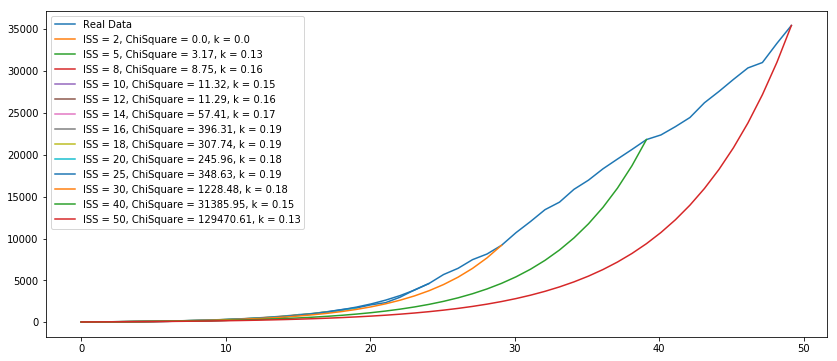

In [9]:
### Try getting k from first few days 
### Try getting k from first few days 
ISS = [2, 5, 8, 10, 12, 14, 16, 18, 20, 25, 30, 40, 50]
plt.rcParams['figure.figsize'] = [14, 6]
ISS_k = []
time = np.linspace(0, len(cases), len(cases))

for i in ISS: 
    FirstDay = cases[0]
    Days = i
    LastDay = cases[Days-1]
    k = FitFunction(FirstDay,LastDay, Days)
    ISS_k.append(k)
    
fig7, axs7 = plt.subplots()
axs7.plot(time[:max(ISS)], cases[:max(ISS)], label  = "Real Data")
for i in range(len(ISS_k)):
    Fit = FittedFunction(FirstDay, ISS_k[i], ISS[i])
    ChiSq = 0
    for j in range(len(Fit)):
        deviation = abs(cases[j] - Fit[j])
        ChiSq = (deviation**2)*(1/cases[j]) + ChiSq
    axs7.plot(time[:ISS[i]], Fit, label = "ISS = " + str(ISS[i]) + ", ChiSquare = " + str(round(ChiSq, 2)) + ", k = " + str(round(ISS_k[i], 2)))
plt.legend()

# Check residuals from ISS fit to data


### calculate standard error on infections due to fit of k
formula: 

$\sigma_{infections} = \sqrt{\sum\frac{\left(x_{actual}-x_{fitted}\right)^2}{N}}$

$\overline{x} = \frac{\sigma}{\sqrt{n}}$


In [10]:
### error on k 
ISS = 14
k = FitFunction(cases[0], cases[13], 14)

Fit = FittedFunction(FirstDay, k, 14)
actual = cases[:14]

SUM = 0
for i in range(len(actual)):
    print(actual[i], Fit[i])
    SUM = SUM + (actual[i] - Fit[i])**2

sigma = ((SUM)*(1/14))**(1/2)

print(sigma)

### calculate upper and lower limits on k using upper and lower limits of one standard dev on sigma

k_upper = FitFunction(cases[0], cases[13]+sigma, 14)
k_lower = FitFunction(cases[0], cases[13]-sigma, 14)

print(k_upper, k_lower)

print(cases[14])



53.0 53.0
53.0 62.819821629136094
60.0 74.45905640597122
69.0 88.25480456786595
88.0 104.60662416731329
114.0 123.98810323427732
133.0 146.96057602475875
157.0 174.18938061114034
202.0 206.46312867323647
202.0 244.71654558954884
252.0 290.05754233271335
293.0 343.79930323635176
335.0 407.4983189722433
483.0 482.999466264323
30.08527184231688
0.174626933824628 0.16503168893456882
611.0


### Uperr and lower limits on k


Upper and lower limits from k are found using range of one standard deviation from the number of cases on the ISS day (ISS=day 14, initial steady state growth stage).


$k_{upper} = \frac{1}{t_{ISS}}\ln{\frac{I(t_{ISS})+\sigma_{infections}}{I_0}}$


$k_{lower} = \frac{1}{t_{ISS}}\ln{\frac{I(t_{ISS})-\sigma_{infections}}{I_0}}$

$k_{upper}$ = 0.175

$k_{upper}$ = 0.165

$k_{actual}$ = 0.17

In [11]:
def SIR(I0, N, k, g, dt, duration):
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R = np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    R[0] = g*I0 # set initial values as given. 
    I[0] = I0
    S[0] = N-1
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        dS = -(k/N) * S[i-1]*I[i-1]*dt
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        S[i] = S[i-1]+dS
    return S, I, R   # return S, I, and R arrays indexed by time.

/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


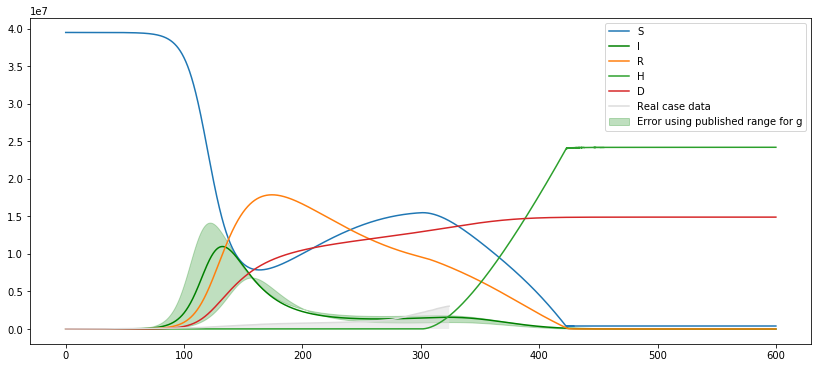

In [45]:
### plot with error due to published values of g
I0 = cases[0]
N = 39.5*10**6 # actual population of CA
k = 0.17
g_true = 1/16 # from papers (not from data), estimate serial days is 8
g_lower = 1/12 # lower limit of serial days is 6
g_upper = 1/20 # upper limit serial days is 10
v = N * 0.01
duration = 600 
r = 50
lag = 300 # from katherine from papers
A = 0.01
d = 0.016
dt = 0.001
w = 90

fig2, axs2 = plt.subplots()

x = np.linspace(0, duration, duration/dt)
S, I, R, H, D = SIRHD(I0, N, k, g_true, v, lag, r, A, d, w, dt, duration)
a, i_lower,b ,c, f = SIRHD(I0, N, k, g_lower, v, lag, r, A, d, w, dt, duration)
a, i_upper, b, c, f = SIRHD(I0, N, k, g_upper, v, lag, r, A, d, w, dt, duration)
plt.plot(x, S, label = "S")
plt.plot(x, i_lower, color = "green", alpha = 0)
plt.plot(x, i_upper, color = "green", alpha = 0)
axs2.fill_between(x, i_lower, i_upper, color = "green", alpha = 0.25, label = "Error using published range for g")
plt.plot(x, I, label = "I", color = "green")
plt.plot(x, R, label = "R")
plt.plot(x, H, label = "H")
plt.plot(x, D, label = "D")

time = np.linspace(0,len(cases), len(cases))
axs2.plot(time[:len(cases)], cases, label = "Real case data", color = "gainsboro")
axs2.fill_between(time[:len(cases)], 0, cases, facecolor = "gainsboro", alpha = 0.5)
axs2.legend()

/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


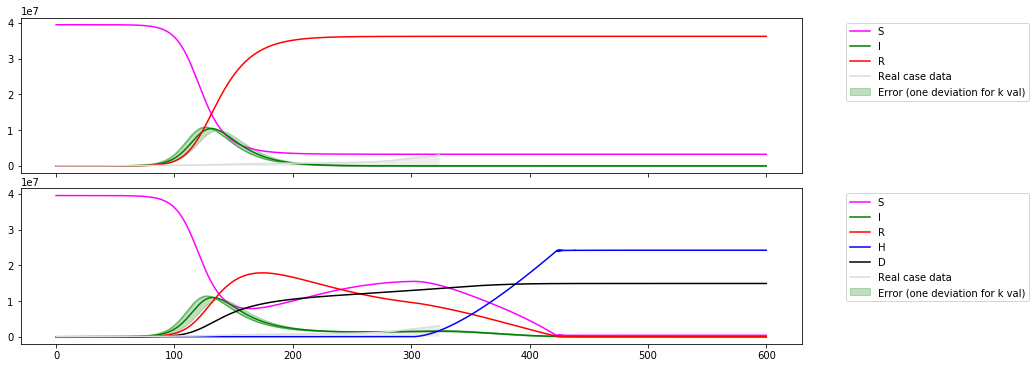

In [15]:
### plot with error on k, one standard dev. also using g =1/16, from paper
I0 = cases[0]
N = 39.5*10**6 # actual population of CA
k = 0.17

g_true = 1/16 # from papers (not from data), estimate serial days is 8

v = N * 0.01
duration = 600 
r = 50
lag = 300 # from katherine from papers
A = 0.01
d = 0.016
dt = 0.001
w = 90
plt.rcParams['figure.figsize'] = [14, 6]
fig3, axs3 = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1})

x = np.linspace(0, duration, duration/dt)
S, I, R, H, D = SIRHD(I0, N, k, g_true, v, lag, r, A, d, w, dt, duration)
a, i_lower,b ,c, f = SIRHD(I0, N, k_lower, g_true, v, lag, r, A, d, w, dt, duration)
a, i_upper, b, c, f = SIRHD(I0, N, k_upper, g_true, v, lag, r, A, d, w, dt, duration)
axs3[1].plot(x, S, label = "S", color = "magenta")
axs3[1].plot(x, i_lower, color = "green", alpha = 0)
axs3[1].plot(x, i_upper, color = "green", alpha = 0.5)
axs3[1].fill_between(x, i_lower, i_upper, color = "green", alpha = 0.25, label = "Error (one deviation for k val)")
axs3[1].plot(x, I, label = "I", color = "green")
axs3[1].plot(x, R, label = "R", color = "red")
axs3[1].plot(x, H, label = "H", color = "blue")
axs3[1].plot(x, D, label = "D", color = "black")

time = np.linspace(0,len(cases), len(cases))
axs3[1].plot(time[:len(cases)], cases, label = "Real case data", color = "gainsboro")
axs3[1].fill_between(time[:len(cases)], 0, cases, facecolor = "gainsboro", alpha = 0.5)
axs3[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

S, I, R = SIR(I0, N, k, g_true, dt, duration)
a, i_lower,b = SIR(I0, N, k_lower, g_true, dt, duration)
a, i_upper, b = SIR(I0, N, k_upper, g_true, dt, duration)
axs3[0].plot(x, S, label = "S", color = "magenta")
axs3[0].plot(x, i_lower, color = "green", alpha = 0)
axs3[0].plot(x, i_upper, color = "green", alpha = 0.5)
axs3[0].fill_between(x, i_lower, i_upper, color = "green", alpha = 0.25, label = "Error (one deviation for k val)")
axs3[0].plot(x, I, label = "I", color = "green")
axs3[0].plot(x, R, label = "R", color = "red")

time = np.linspace(0,len(cases), len(cases))
axs3[0].plot(time[:len(cases)], cases, label = "Real case data", color = "gainsboro")
axs3[0].fill_between(time[:len(cases)], 0, cases, facecolor = "gainsboro", alpha = 0.5)
axs3[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()